In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
df_rt_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', compression='gzip')
df_rt_rev = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='iso-8859-1')

Looking at these two dataframes, I want to join review data to the movie data, but this would be a many-to-one join and would make an extremely large and unworkable merge. Therefore, I want to create an indicator of average review for each movie so I can add columns to the rt_info dataframe. After previewing the 'rating' column, I can see that the scale of ratings is different in many instances, and some are numerical while some are not. Since it would be pretty messy to try and make this column workable, I am instead going to use the 'fresh' column to get a percentage of overall positive reviews. 

In [2]:
# insert a new column with a value of zero 
df_rt_rev['fresh_ind'] = 0

# loop through the data and input a 1 where the rating is 'fresh'
for row in df_rt_rev.index:
    if df_rt_rev['fresh'][row] == 'fresh':
        df_rt_rev['fresh_ind'][row] = 1

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [3]:
# pivot the data to look at aggregate values by movie: total ratings (count), and total positive ratings (sum)
df_grouped = df_rt_rev.groupby(['id'])['fresh_ind'].agg(['count', 'sum'])

#insert a column to get a % of total positive reviews
df_grouped['fresh_pct'] = df_grouped['sum'] / df_grouped['count']
df_grouped.reset_index()
df_grouped.head(2)

,count,sum,fresh_pct
id,,,
3,163,103,0.631902
5,23,18,0.782609


There are fewer movies in the reviews df, so I am going to do an inner join so that I can get only results where there are reviews. 

In [4]:
rt_all = pd.merge(df_rt_info, df_grouped, how='inner', on='id')

In [5]:
#create a column for release year by changing the current dates to datetime and separating
rt_all['theater_date'] = pd.to_datetime(rt_all['theater_date'])
rt_all['release_year'] = rt_all['theater_date'].dt.year

#fill nas so I can work with the data
rt_all['release_year'] = rt_all['release_year'].fillna(0)

#dates are coming up as floats so I am changing them to integers
rt_all = rt_all.astype({'release_year': 'int64'})

There are significantly fewer results in this data than in the other sources that I am using, so I am extending the date range back to 2010.

In [7]:
rt_filtered = rt_all[(rt_all['release_year'] >= 2010)]

In [8]:
genres = rt_filtered['genre'].str.split("|", n = 1, expand = True)
rt_filtered['genre1']= genres[0]
rt_filtered['genre2']= genres[1]
genres2 = rt_filtered['genre2'].str.split("|", n = 1, expand = True)
rt_filtered['genre2']= genres2[0]
rt_filtered['genre3']= genres2[1]
rt_filtered.head(20)

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a c

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,count,sum,fresh_pct,release_year,genre1,genre2,genre3
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,"Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,163,103,0.631902,2012,Drama,Science Fiction and Fantasy,None
6,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,2010-06-30,"Nov 9, 2010",$,"134,904",117 minutes,NaN,42,6,0.142857,2010,Drama,None,None
12,23,A fictional film set in the alluring world of ...,R,Drama,NaN,NaN,2013-12-20,"Mar 18, 2014",$,"99,165,609",129 minutes,Sony Pictures,233,213,0.914163,2013,Drama,None,None
14,25,"From ancient Japan's most enduring tale, the e...",PG-13,Action and Adventure|Drama|Science Fiction and...,Carl Erik Rinsch,Chris Morgan|Hossein Amini,2013-12-25,"Apr 1, 2014",$,"20,518,224",127 minutes,Universal Pictures,37,4,0.108108,2013,Action and Adventure,Drama,Science Fiction and Fantasy
31,54,Journalist Jep Gambardella (the dazzling Toni ...,NR,Comedy|Drama,Paolo Sorrentino,Paolo Sorrentino|Umberto Contarello,2013-11-15,"Mar 25, 2014",NaN,NaN,142 minutes,Janus Films,106,95,0.896226,2013,Comedy,Drama,None
33,57,Life doesn't always go according to plan. Pat ...,R,Comedy,NaN,NaN,2012-11-21,"Apr 30, 2013",$,"132,088,910",122 minutes,The Weinstein Company,196,182,0.928571,2012,Comedy,None,None
41,67,"After a mysterious, lost night on their honeym...",R,Horror,Matt Bettinelli-Olpin|Tyler Gillett,Lindsay Devlin,2014-01-17,"Apr 29, 2014",NaN,NaN,89 minutes,20th Century Fox,51,10,0.196078,2014,Horror,None,None
47,77,"Until he was downsized, affable, amiable Larry...",PG-13,Comedy|Drama,Tom Hanks,Tom Hanks|Nia Vardalos,2011-07-01,"Nov 15, 2011",$,"35,565,975",99 minutes,Universal Pictures,183,66,0.360656,2011,Comedy,Drama,None
51,87,"""Mao's Last Dancer"" is the inspiring true stor...",PG,Art House and International|Drama|Musical and ...,Bruce Beresford,Jan Sardi,2010-08-20,"May 3, 2011",$,"4,806,750",117 minutes,Samuel Goldwyn Films,63,36,0.571429,2010,Art House and International,Drama,Musical and Performing Arts
56,95,BLEED FOR THIS is the incredible true story of...,R,Drama|Sports and Fitness,Ben Younger,Ben Younger,2016-11-18,"Feb 14, 2017",$,"5,051,927",116 minutes,Open Road Films,125,86,0.688000,2016,Drama,Sports and Fitness,None


In [9]:
#get a list of all genres - the first 2 columns cover them all
genrelist1 = list(rt_filtered['genre1'].unique())
genrelist2 = list(rt_filtered['genre2'].unique())
genrelist_all = set(genrelist1 + genrelist2)
genrelist_all 

{'Action and Adventure',
 'Animation',
 'Art House and International',
 'Comedy',
 'Documentary',
 'Drama',
 'Horror',
 'Kids and Family',
 'Musical and Performing Arts',
 'Mystery and Suspense',
 None,
 'Romance',
 'Science Fiction and Fantasy',
 'Special Interest',
 'Sports and Fitness',
 'Western'}

In [10]:
def avg_rating_by_genre_rt(genre):
    genre_counts = []
    genre_sums = []
    for row in rt_filtered.index:
        if (rt_filtered['genre1'][row] == genre) | (rt_filtered['genre2'][row] == genre) | (rt_filtered['genre2'][row] == genre):
            genre_counts.append(rt_filtered['count'][row])
            genre_sums.append(rt_filtered['sum'][row])
    genreavg = (sum(genre_sums) / sum(genre_counts))
    return genreavg

In [11]:
genre_dict_rt = {}
for genre in genrelist_all:
    value = avg_rating_by_genre_rt(genre)
    key = genre 
    genre_dict_rt[key] = value

In [52]:
genre_dict_rt

{'Romance': 0.7539556962025317,
 'Kids and Family': 0.539568345323741,
 'Comedy': 0.6409075961854653,
 'Art House and International': 0.7368421052631579,
 'Action and Adventure': 0.5514285714285714,
 'Documentary': 0.9076923076923077,
 'Sports and Fitness': 0.688,
 'Science Fiction and Fantasy': 0.47297297297297297,
 None: 0.6606098909780376,
 'Western': 0.3275862068965517,
 'Mystery and Suspense': 0.6157007809288944,
 'Drama': 0.6926089084679393,
 'Horror': 0.5098039215686274,
 'Special Interest': 0.4,
 'Musical and Performing Arts': 0.39672131147540984,
 'Animation': 0.6402366863905326}

In [53]:
genre_df_rt = pd.DataFrame(list(genre_dict_rt.items()),columns = ['Genre','Average Fresh Score']) 
genre_df_rt = genre_df_rt.sort_values('Average Fresh Score', ascending = False)
genre_df_rt = genre_df_rt.reset_index()

In [63]:
genre_df_rt = genre_df_rt.dropna()
genre_df_rt

,index,Genre,Average Fresh Score
0,5,Documentary,0.907692
1,0,Romance,0.753956
2,3,Art House and International,0.736842
3,11,Drama,0.692609
4,6,Sports and Fitness,0.688000
6,2,Comedy,0.640908
7,15,Animation,0.640237
8,10,Mystery and Suspense,0.615701
9,4,Action and Adventure,0.551429
10,1,Kids and Family,0.539568


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

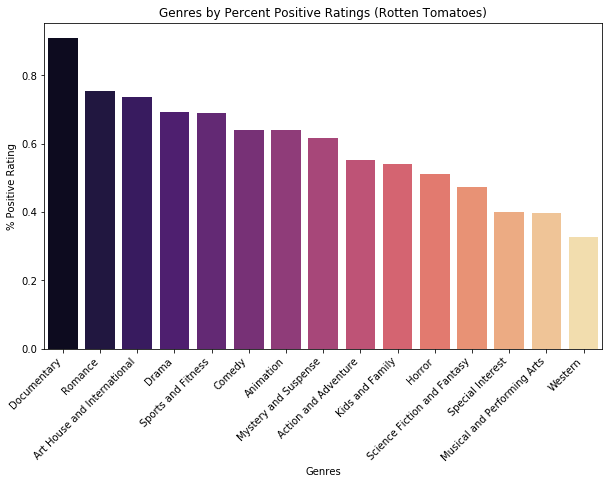

In [74]:
plt.figure (figsize=(10,6))
ax = sns.barplot(x=genre_df_rt['Genre'], y=genre_df_rt['Average Fresh Score'], palette='magma')
plt.title('Genres by Percent Positive Ratings (Rotten Tomatoes)')
plt.xlabel('Genres')
plt.ylabel('% Positive Rating')
plt.xticks(rotation = 45, horizontalalignment="right")

While the methodology is pretty different here, it looks like documentaries are still the top rated genre. However, music looks like it's on the lower end compared to IMDB rankings. Let's consider the second, third, and fourth result. While Romance and Drama weren't in the top categories in the IMDB data, they were still above average. Art House and International is a pretty vague category, but may recall some of our top revenue-driving movies with lower budgets from the budgets data.